# Web Scrapping of Github Repositories and Analysis of scrapped data

Here I will scrape github repositories and organize the information in a Pandas dataframe. In Part 2,I will use linear regression to gain meaningful insights. 

In [2]:
# imports and setup 
from bs4 import BeautifulSoup
import requests
import urllib.request


import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### 1. Scrape Github Repository List and Repository Information using BeautifulSoup
In this part I will explore over 2 million Github repositories.
(https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

and download the first ten pages of the list of highly starred repositories here: 
https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories

In [4]:
# download the fist ten pages
from bs4 import BeautifulSoup
import requests
import urllib.request
from time import time
from time import sleep
html1=bytes()
#url= "https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories"
pages = [str(i) for i in range(1,11)]
for page in pages:
    url="https://github.com/search?o=desc&p="+page+"&q=stars%3A%3E1&s=stars&type=Repositories"
    #print(url)
    req = urllib.request.Request(url)
    sleep(30) 
    with urllib.request.urlopen(req) as response:
        html = response.read()
        html1=html+html1

In [5]:
# Creating the soup
gitrepo_soup= BeautifulSoup(html1, 'html.parser')
#print(gitrepo_soup.prettify())
#print(html1)

### Extract Data

Extracted the foolowing data for each repository, and created a Pandas Dataframe with a row for each repository and a column for each of these datums. 

1. Name of the repository
+ URL of the repository 
+ Number of Contributors 
+ Programming Language Used 
+ Number of stars 
+ Number of issues
+ Number of files 
+ Length of readme file.


In [6]:
gitrepo_contain= gitrepo_soup.find_all('div', class_= 'repo-list-item d-flex flex-justify-start py-4 public source')

name=[]
link=[]
language=[]
noofstars=[]


for rep in gitrepo_contain:
    nam=rep.h3.a.text
    name.append(nam)
    
    lin="https://github.com"+rep.h3.a["href"]
    link.append(lin)
    
    lang=rep.find('div', class_='d-table-cell col-2 text-gray pt-2')
    lang=lang.text
    lang=lang.strip()
    language.append(lang)
    
    nofstar=rep.find('div', class_='col-2 text-right pt-1 pr-3 pt-2')
    nofstar=nofstar.a.text
    nofstar=nofstar.strip()
    noofstars.append(nofstar)
    

In [34]:
import re
issues=[]
forks=[]
contributers=[]
readmelength=[]
count=0
for li in link:
    url007=li
    #count=count+1
    #print(count)
    #print(url)
    req007 = urllib.request.Request(url007)
    #sleep(10) 
    with urllib.request.urlopen(req007) as response:
        html2 = response.read()
    gitrepo_soup007= BeautifulSoup(html2, 'html.parser')
    if gitrepo_soup007.find('article',class_="markdown-body entry-content") is not None:
        iss=gitrepo_soup007.find('span', class_="Counter").text
        issues.append(iss)
    
        frk=gitrepo_soup007.find('a', href=re.compile("/network")).text.strip()
        forks.append(frk)
    
        contri=gitrepo_soup007.find('a',href=re.compile("/contributors")).span.text.strip()
        contributers.append(contri)
    
    
        rdm=gitrepo_soup007.find('article',class_="markdown-body entry-content") 
        rdm_len=len(rdm.text)
        readmelength.append(rdm_len)
    else:
        readmelength.append(0)
        iss=gitrepo_soup007.find('span', class_="Counter").text
        issues.append(iss)
    
        frk=gitrepo_soup007.find('a', href=re.compile("/network")).text.strip()
        forks.append(frk)
    
        contri=gitrepo_soup007.find('a',href=re.compile("/contributors")).span.text.strip()
        contributers.append(contri)
    

In [35]:
#Convert list into DataFrame
import pandas as pd

gitrepo_df = pd.DataFrame({'Name of the repository': name,
                           'URL': link,
                           'Language': language,
                           'Stars': noofstars,
                           'Forks':forks,
                           'Issues':issues,
                           'Contributors':contributers,
                           'ReadmeLength':readmelength})


In [25]:
#Saved dataframe to file project_info.csv
gitrepo_df.to_csv('project_info.csv')

### 2. linear regression to analyze the Github repository data

In this part, I analyzed the data collectd in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 


In [30]:
# this loads the data from the project_info.csv file 
project_info = pd.read_csv('project_info.csv')
del project_info['Unnamed: 0']
project_info.head(5)

,Contributors,Forks,Issues,Language,Name of the repository,ReadmeLength,Stars,URL
0,514,"16,728",606,C++,bitcoin/bitcoin,2957,28.2k,https://github.com/bitcoin/bitcoin
1,767,"3,630",9,Go,avelino/awesome-go,104719,28.1k,https://github.com/avelino/awesome-go
2,154,"2,315",324,C,firehol/netdata,8327,27.7k,https://github.com/firehol/netdata
3,244,"10,594","1,038",C,antirez/redis,19514,27.6k,https://github.com/antirez/redis
4,118,"1,807",237,JavaScript,GoogleChrome/puppeteer,9096,27.1k,https://github.com/GoogleChrome/puppeteer


### Reformating the data into useful datatypes

+ Reformated the colums Issues, Forks, Stars, and Contributers to be integer data
+ There is one repository flagged as having infinite contributers (the Linux kernel). We'll assume that it in fact has 15000 contributors (about twice as much as the next project). 

In [31]:
print(project_info.dtypes)

Contributors              object
Forks                     object
Issues                    object
Language                  object
Name of the repository    object
ReadmeLength               int64
Stars                     object
URL                       object
dtype: object


In [32]:
project_info['Contributors']=project_info['Contributors'].replace('?','15000')
project_info['Issues'] = project_info['Issues'] .str.replace(',','').astype(int)
project_info['Forks'] = project_info['Forks'] .str.replace(',','').astype(int)
project_info['Stars']=project_info['Stars'].astype(str).str.replace(r"k",'')
project_info['Stars']=project_info['Stars'].astype(float)
for i in range(0,100):
    project_info['Stars'][i]= project_info['Stars'][i]*1000
project_info['Stars']=project_info['Stars'].astype(int)
#project_info['Contributors']=project_info['Contributors'].str.replace(',','').astype(int)

C:\Users\Pratik S\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [33]:
print(project_info.dtypes)

Contributors              object
Forks                      int32
Issues                     int32
Language                  object
Name of the repository    object
ReadmeLength               int64
Stars                      int32
URL                       object
dtype: object


In [113]:
project_info.sort_values('Stars',ascending=False).head()

,Contributors,Forks,Issues,Language,Name of the repository,ReadmeLength,Stars,URL
90,733,13488,165,JavaScript,freeCodeCamp/freeCodeCamp,68,292000,https://github.com/freeCodeCamp/freeCodeCamp
91,985,57790,320,CSS,twbs/bootstrap,91,122000,https://github.com/twbs/bootstrap
92,981,25856,17,NaN,EbookFoundation/free-programming-books,50,102000,https://github.com/EbookFoundation/free-progra...
93,1347,58596,1191,C++,tensorflow/tensorflow,50,90300,https://github.com/tensorflow/tensorflow
94,1167,16849,332,JavaScript,facebook/react,56,89100,https://github.com/facebook/react


### Describing the data

+ Overview of the data using the describe function.
+ Computing the correlation matrix, visualizing it with a heat map.
+ Visualizing the correlations by making a scatterplot matrix.
+ Interpretation


In [114]:
project_info.describe()

,Contributors,Forks,Issues,ReadmeLength,Stars
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,711.81000,9572.160000,570.600000,131.810000,43233.000000
std,1650.32214,8850.954365,966.466197,170.216066,30710.097885
min,2.00000,663.000000,0.000000,0.000000,26600.000000
25%,127.00000,4775.000000,31.750000,40.000000,29900.000000
50%,288.50000,7473.000000,174.000000,67.000000,33650.000000
75%,732.25000,11590.000000,535.000000,147.000000,43675.000000
max,15000.00000,58596.000000,4389.000000,886.000000,292000.000000


In [115]:
project_info.corr()

,Contributors,Forks,Issues,ReadmeLength,Stars
Contributors,1.000000,0.252824,0.086927,-0.136849,0.070744
Forks,0.252824,1.000000,0.012584,-0.122497,0.462809
Issues,0.086927,0.012584,1.000000,-0.135893,-0.054951
ReadmeLength,-0.136849,-0.122497,-0.135893,1.000000,-0.044612
Stars,0.070744,0.462809,-0.054951,-0.044612,1.000000


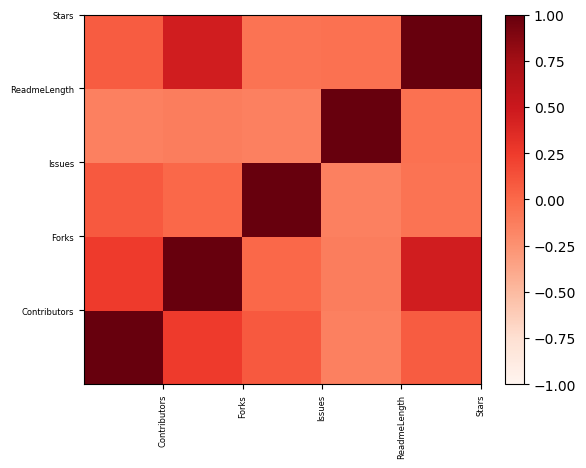

In [123]:
import matplotlib.pyplot as py
from pylab import *
Data= project_info.corr()

plt.style.use('default')
heatmap = plt.pcolor(Data, cmap=plt.cm.Reds, vmin=-1 , vmax=1)
plt.colorbar(heatmap)
plt.legend

xticks( arange(1,6),('Contributors','Forks','Issues','ReadmeLength','Stars'),fontsize=6, rotation=90);
yticks( arange(1,6),('Contributors','Forks','Issues','ReadmeLength','Stars'),fontsize=6 );

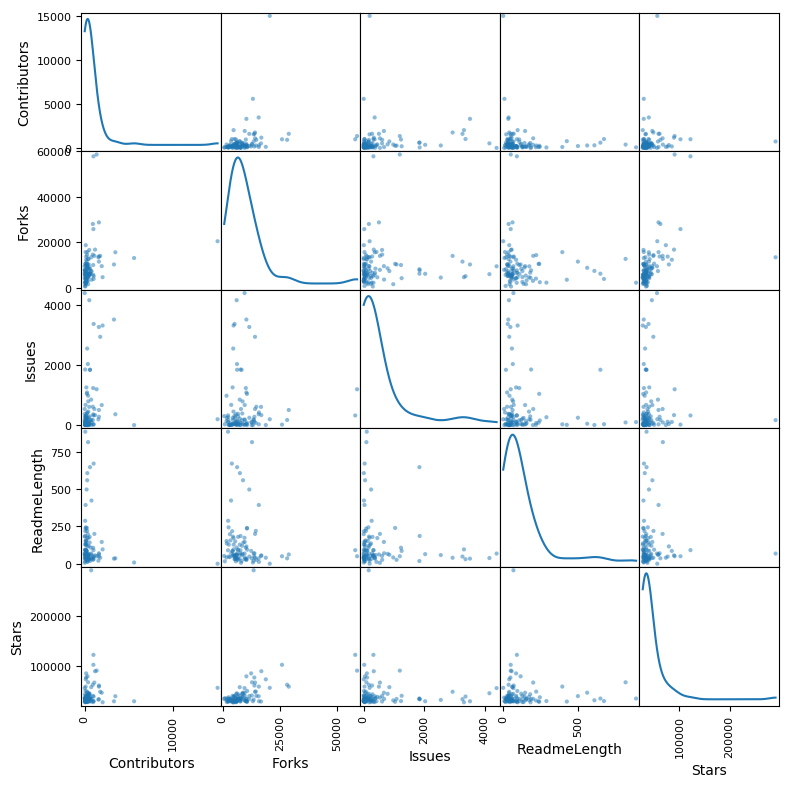

In [124]:
pd.plotting.scatter_matrix(project_info[['Contributors','Forks','Issues','ReadmeLength','Stars']], figsize=(9, 9), diagonal='kde');

**Interpretation:** The Highest correlation is between number of stars and forks, which tells us they are closely related compared to others, althoigh the correlation is not very significant. The mean amount of contributors is 711, the highest amount of stars is 292k which is for freeCodeCamp/freeCodeCamp, which tells us that it is the most popular repository amongst all. 

Looking at the scatter plot , there is no significant relation between any two values.

### Linear regression and Model Building

1. linear regression to try to predict the number of Stars based on Forks, Contributors, Issues, and Readme Length.
+ Developing another model which is better. . 

In [154]:
import scipy as sc
from scipy.stats import norm
import pandas as pd
import statsmodels.formula.api as sm

Projectinfo_Linear_ols = sm.ols(formula="Stars ~ Forks+Contributors+Issues+ReadmeLength", data=project_info).fit()
Projectinfo_Linear_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     6.687
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           8.72e-05
Time:                        08:00:50   Log-Likelihood:                -1162.2
No. Observations:                 100   AIC:                             2334.
Df Residuals:                      95   BIC:                             2347.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      2.91e+04   5236.973      5.556      0.000    1.87e+04    3.95e+04
Forks            1.6471      0.326      5.045      0.000       0.999       2.295
Contributors    -0.8253      1.758     -0.469      0.640      -4.316       2.666
Issues          -1.8147      2.914     -0.623      0.535      -7.601       3.971
ReadmeLength    -0.0527     16.712     -0.003      0.997     -33.230      33.124
==============================================================================
Omnibus:                      180.957   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16547.788
Skew:                           7.203   Prob(JB):                         0.00
Kurtosis:                      64.351   Cond. No.                     2.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [153]:
Projectinfo_Linear_ols1 = sm.ols(formula="Stars ~ Forks+Contributors+Issues", data=project_info).fit()
Projectinfo_Linear_ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     9.010
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           2.57e-05
Time:                        08:00:02   Log-Likelihood:                -1162.2
No. Observations:                 100   AIC:                             2332.
Df Residuals:                      96   BIC:                             2343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.909e+04   4382.283      6.638      0.000    2.04e+04    3.78e+04
Forks            1.6472      0.323      5.094      0.000       1.005       2.289
Contributors    -0.8247      1.741     -0.474      0.637      -4.280       2.630
Issues          -1.8135      2.876     -0.631      0.530      -7.522       3.895
==============================================================================
Omnibus:                      180.962   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16549.740
Skew:                           7.203   Prob(JB):                         0.00
Kurtosis:                      64.355   Cond. No.                     2.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""